# 🇹🇿 Tanzania Infant Mortality — Regression Modelling
**Models:** Linear Regression & Decision Tree Regressor  
**Target:** Predict infant mortality rate (deaths per 1,000 live births)

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib, json

print('✅ Libraries imported successfully')

✅ Libraries imported successfully


## 2. Load & Explore Data

In [2]:
df = pd.read_excel('tanzania_infant_mortality_dataset.xlsx')
df.columns = ['ID', 'Region', 'Area', 'Skilled_Birth_Pct', 'Clinic_Vaccination_Pct', 'Clean_Water_Pct', 'Infant_Mortality']

print('Shape:', df.shape)
df.head(10)

Shape: (500, 7)


,ID,Region,Area,Skilled_Birth_Pct,Clinic_Vaccination_Pct,Clean_Water_Pct,Infant_Mortality
0,TZ-1000,Njombe,Vijijini,70.0,82.2,65.0,31.6
1,TZ-1001,Lindi,Vijijini,52.0,71.3,91.9,36.8
2,TZ-1002,Kigoma,Vijijini,54.1,59.3,42.0,49.3
3,TZ-1003,Dar es Salaam,Vijijini,50.4,69.5,42.3,43.7
4,TZ-1004,Simiyu,Mjini,86.5,79.7,85.5,15.7
5,TZ-1005,Geita,Mjini,90.5,79.9,93.2,11.9
6,TZ-1006,Iringa,Mjini,78.4,82.4,88.7,14.3
7,TZ-1007,Pwani,Vijijini,55.9,55.1,61.8,42.4
8,TZ-1008,Iringa,Vijijini,52.5,70.1,34.1,50.3
9,TZ-1009,Mara,Vijijini,69.3,65.6,20.3,49.7


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      500 non-null    object 
 1   Region                  500 non-null    object 
 2   Area                    500 non-null    object 
 3   Skilled_Birth_Pct       500 non-null    float64
 4   Clinic_Vaccination_Pct  500 non-null    float64
 5   Clean_Water_Pct         500 non-null    float64
 6   Infant_Mortality        500 non-null    float64
dtypes: float64(4), object(3)
memory usage: 27.5+ KB


In [4]:
df.describe().round(2)

,Skilled_Birth_Pct,Clinic_Vaccination_Pct,Clean_Water_Pct,Infant_Mortality
count,500.00,500.00,500.00,500.00
mean,68.93,71.41,67.67,30.39
std,18.96,18.56,23.19,18.65
min,21.50,20.00,15.00,5.00
25%,54.08,59.30,49.78,8.85
50%,69.30,74.25,71.55,35.00
75%,85.88,85.72,88.20,45.82
max,100.00,100.00,100.00,70.90


In [5]:
print('Missing values:')
print(df.isnull().sum())
print()
print('Area distribution:')
print(df['Area'].value_counts())

Missing values:
ID                        0
Region                    0
Area                      0
Skilled_Birth_Pct         0
Clinic_Vaccination_Pct    0
Clean_Water_Pct           0
Infant_Mortality          0
dtype: int64

Area distribution:
Area
Vijijini    321
Mjini       179
Name: count, dtype: int64


## 3. Exploratory Data Analysis

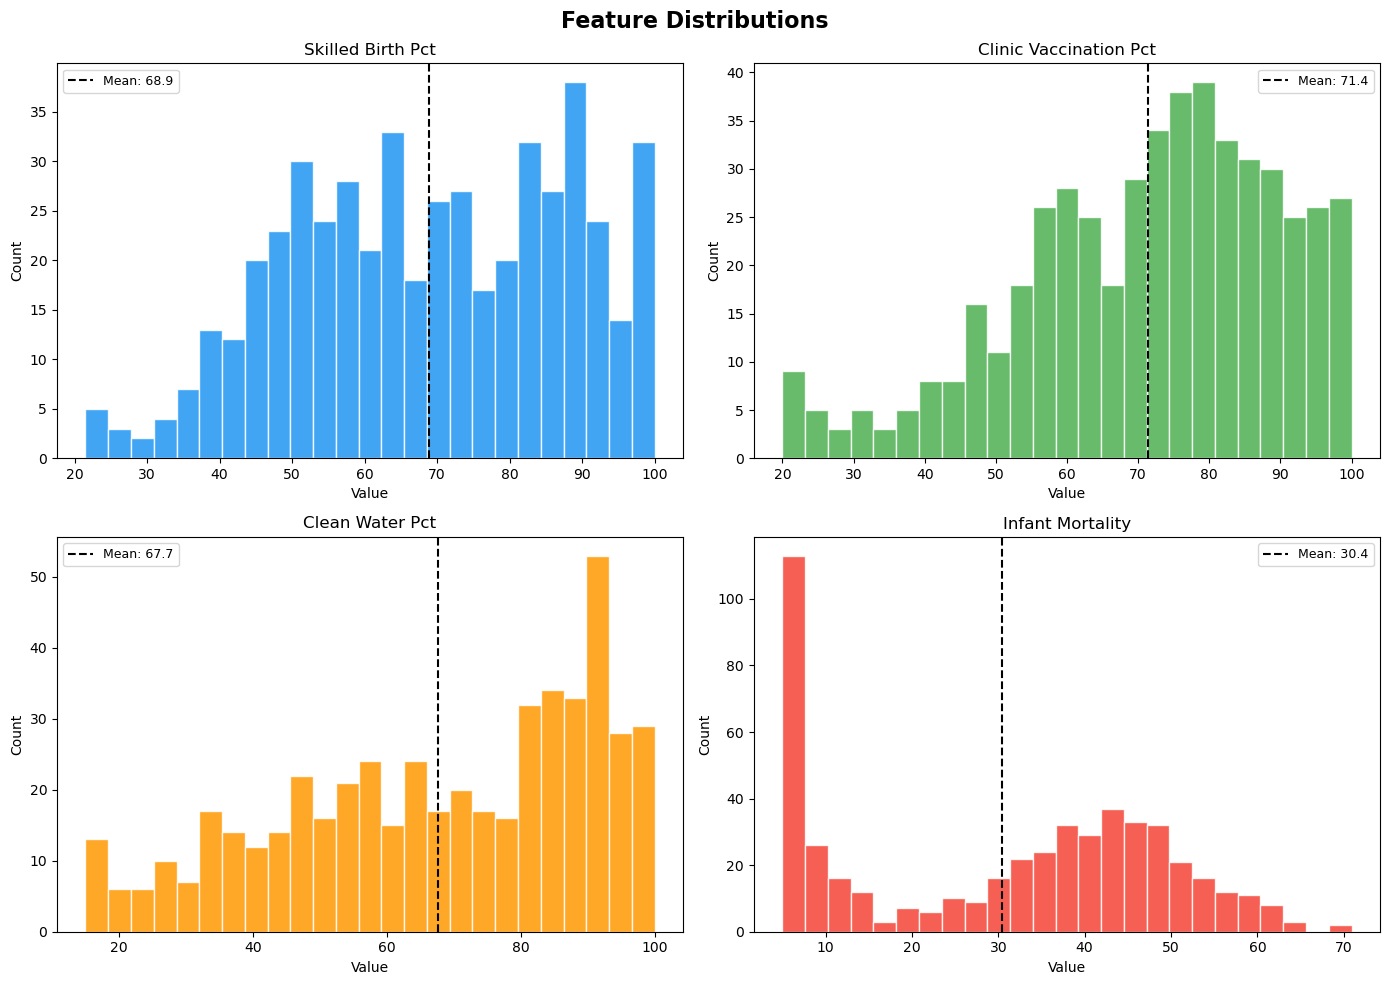

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Feature Distributions', fontsize=16, fontweight='bold')

features = ['Skilled_Birth_Pct', 'Clinic_Vaccination_Pct', 'Clean_Water_Pct', 'Infant_Mortality']
colors   = ['#2196F3', '#4CAF50', '#FF9800', '#F44336']

for ax, feat, color in zip(axes.flatten(), features, colors):
    ax.hist(df[feat], bins=25, color=color, alpha=0.85, edgecolor='white')
    ax.axvline(df[feat].mean(), color='black', linestyle='--', linewidth=1.5, label=f'Mean: {df[feat].mean():.1f}')
    ax.set_title(feat.replace('_', ' '))
    ax.set_xlabel('Value'); ax.set_ylabel('Count')
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

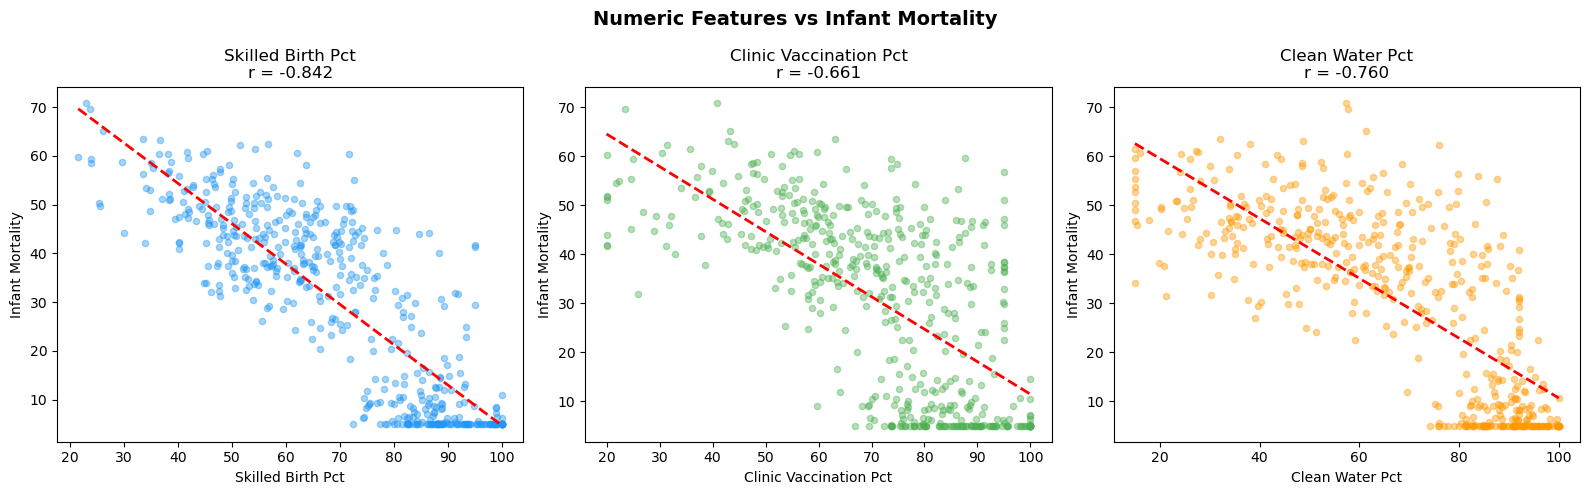

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Numeric Features vs Infant Mortality', fontsize=14, fontweight='bold')

x_features = ['Skilled_Birth_Pct', 'Clinic_Vaccination_Pct', 'Clean_Water_Pct']
colors      = ['#2196F3', '#4CAF50', '#FF9800']

for ax, feat, color in zip(axes, x_features, colors):
    ax.scatter(df[feat], df['Infant_Mortality'], alpha=0.4, color=color, s=20)
    z = np.polyfit(df[feat], df['Infant_Mortality'], 1)
    x_line = np.linspace(df[feat].min(), df[feat].max(), 100)
    ax.plot(x_line, np.poly1d(z)(x_line), 'r--', linewidth=2)
    corr = df[feat].corr(df['Infant_Mortality'])
    ax.set_title(f'{feat.replace("_"," ")}\nr = {corr:.3f}')
    ax.set_xlabel(feat.replace('_', ' ')); ax.set_ylabel('Infant Mortality')

plt.tight_layout()
plt.show()

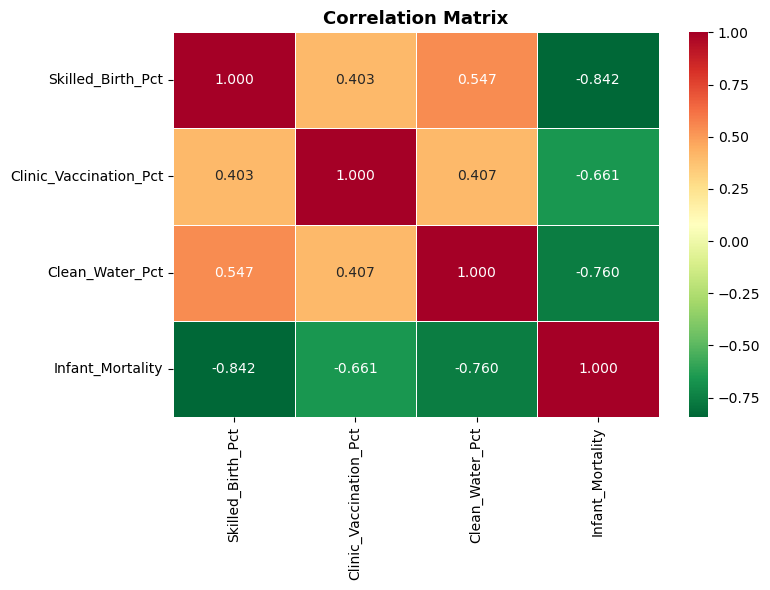

In [8]:
# Correlation heatmap
num_cols = ['Skilled_Birth_Pct', 'Clinic_Vaccination_Pct', 'Clean_Water_Pct', 'Infant_Mortality']
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.3f', cmap='RdYlGn_r', ax=ax, linewidths=0.5)
ax.set_title('Correlation Matrix', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

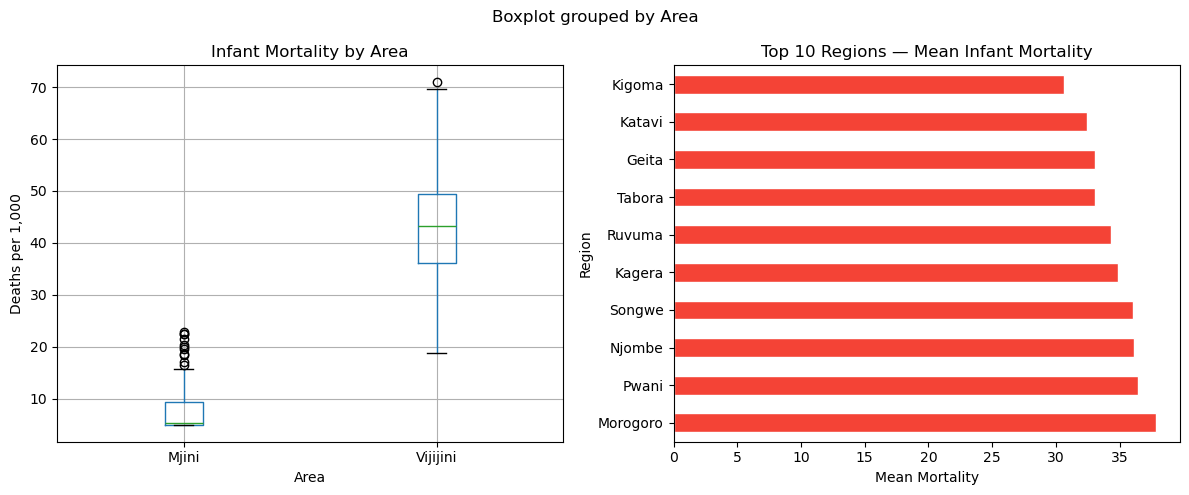

In [9]:
# Boxplot: mortality by area type
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df.boxplot(column='Infant_Mortality', by='Area', ax=axes[0])
axes[0].set_title('Infant Mortality by Area'); axes[0].set_ylabel('Deaths per 1,000')

top_regions = df.groupby('Region')['Infant_Mortality'].mean().sort_values(ascending=False).head(10)
top_regions.plot(kind='barh', ax=axes[1], color='#F44336', edgecolor='white')
axes[1].set_title('Top 10 Regions — Mean Infant Mortality'); axes[1].set_xlabel('Mean Mortality')

plt.tight_layout()
plt.show()

## 4. Preprocessing

In [10]:
# Encode categorical columns
le_area   = LabelEncoder()
le_region = LabelEncoder()
df['Area_Encoded']   = le_area.fit_transform(df['Area'])
df['Region_Encoded'] = le_region.fit_transform(df['Region'])

FEATURES = ['Skilled_Birth_Pct', 'Clinic_Vaccination_Pct', 'Clean_Water_Pct', 'Area_Encoded', 'Region_Encoded']
TARGET   = 'Infant_Mortality'

X = df[FEATURES]
y = df[TARGET]

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale for Linear Regression
scaler      = StandardScaler()
X_train_sc  = scaler.fit_transform(X_train)
X_test_sc   = scaler.transform(X_test)

print(f'Train: {X_train.shape[0]}  |  Test: {X_test.shape[0]}')

Train: 400  |  Test: 100


## 5. Model Training

### 5.1 Linear Regression

In [11]:
lr_model = LinearRegression()
lr_model.fit(X_train_sc, y_train)

lr_pred = lr_model.predict(X_test_sc)
lr_r2   = r2_score(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_mae  = mean_absolute_error(y_test, lr_pred)
lr_cv   = cross_val_score(lr_model, scaler.transform(X), y, cv=5, scoring='r2')

print('=== Linear Regression ===')
print(f'R²:           {lr_r2:.4f}')
print(f'RMSE:         {lr_rmse:.4f}')
print(f'MAE:          {lr_mae:.4f}')
print(f'5-Fold CV R²: {lr_cv.mean():.4f} ± {lr_cv.std():.4f}')

=== Linear Regression ===
R²:           0.9291
RMSE:         4.7039
MAE:          3.7668
5-Fold CV R²: 0.9356 ± 0.0101


### 5.2 Decision Tree Regressor

In [12]:
dt_model = DecisionTreeRegressor(random_state=42, max_depth=5, min_samples_split=10, min_samples_leaf=5)
dt_model.fit(X_train, y_train)

dt_pred = dt_model.predict(X_test)
dt_r2   = r2_score(y_test, dt_pred)
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_pred))
dt_mae  = mean_absolute_error(y_test, dt_pred)
dt_cv   = cross_val_score(dt_model, X, y, cv=5, scoring='r2')

print('=== Decision Tree Regressor ===')
print(f'R²:           {dt_r2:.4f}')
print(f'RMSE:         {dt_rmse:.4f}')
print(f'MAE:          {dt_mae:.4f}')
print(f'5-Fold CV R²: {dt_cv.mean():.4f} ± {dt_cv.std():.4f}')

=== Decision Tree Regressor ===
R²:           0.9005
RMSE:         5.5729
MAE:          4.0370
5-Fold CV R²: 0.8840 ± 0.0159


## 6. Model Evaluation

In [13]:
# Comparison table
summary = pd.DataFrame({
    'Model':   ['Linear Regression', 'Decision Tree'],
    'R²':      [round(lr_r2,4),   round(dt_r2,4)],
    'RMSE':    [round(lr_rmse,4), round(dt_rmse,4)],
    'MAE':     [round(lr_mae,4),  round(dt_mae,4)],
    'CV R² Mean': [round(lr_cv.mean(),4), round(dt_cv.mean(),4)],
    'CV R² Std':  [round(lr_cv.std(),4),  round(dt_cv.std(),4)],
})
summary

,Model,R²,RMSE,MAE,CV R² Mean,CV R² Std
0,Linear Regression,0.9291,4.7039,3.7668,0.9356,0.0101
1,Decision Tree,0.9005,5.5729,4.0370,0.8840,0.0159


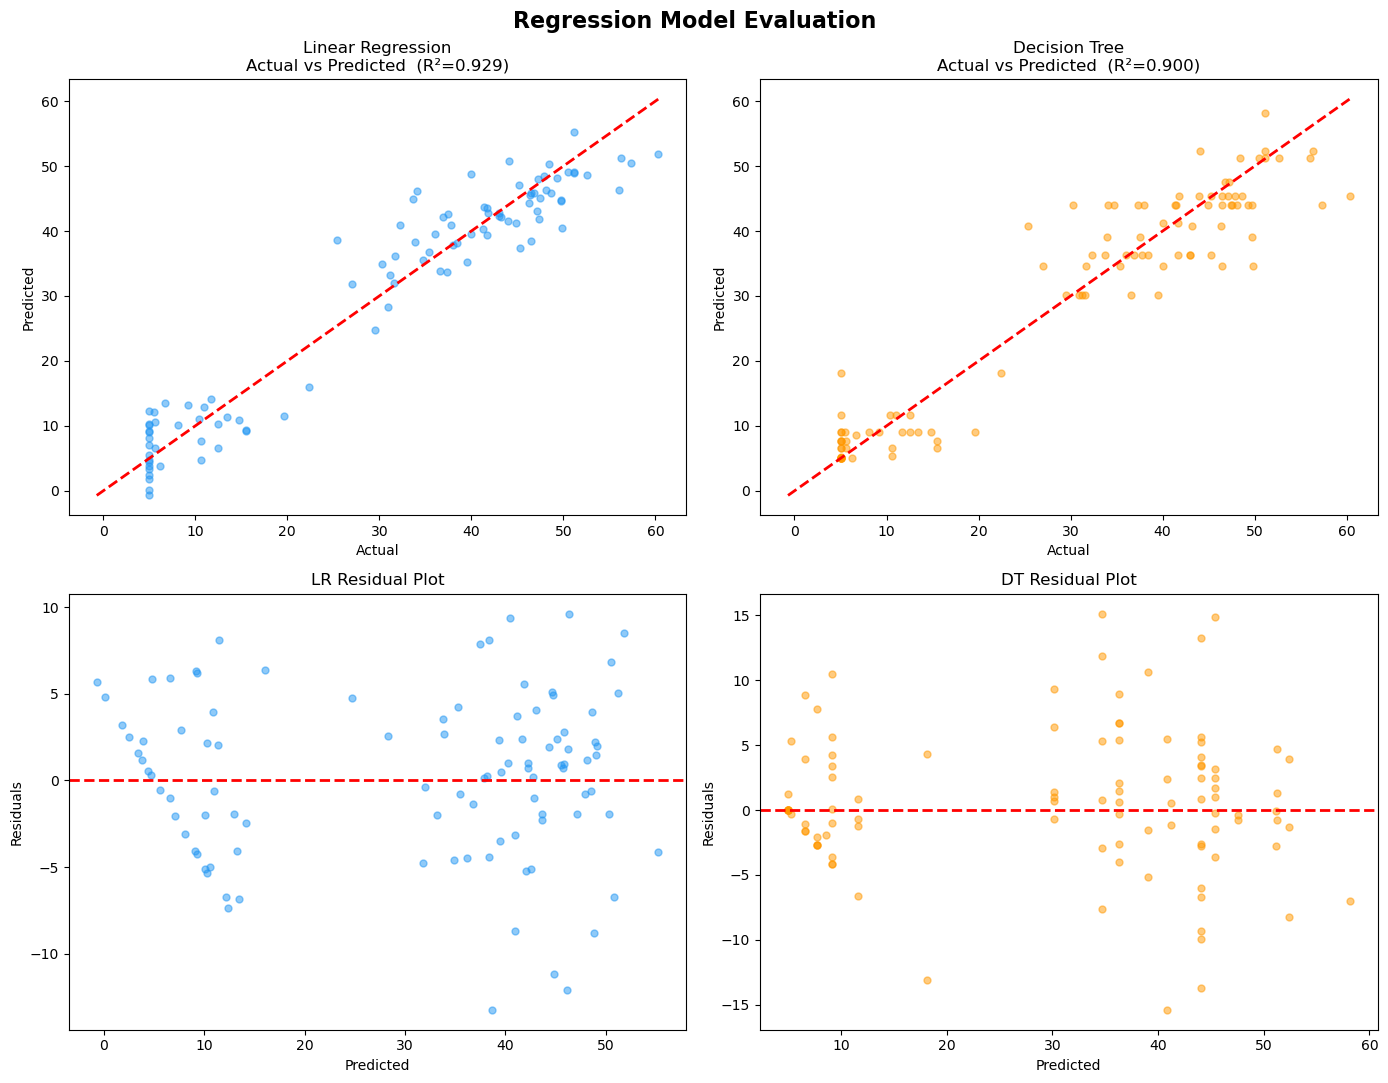

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 11))
fig.suptitle('Regression Model Evaluation', fontsize=16, fontweight='bold')

# Actual vs Predicted — LR
axes[0,0].scatter(y_test, lr_pred, alpha=0.5, color='#2196F3', s=25)
lims = [min(y_test.min(), lr_pred.min()), max(y_test.max(), lr_pred.max())]
axes[0,0].plot(lims, lims, 'r--', linewidth=2)
axes[0,0].set_xlabel('Actual'); axes[0,0].set_ylabel('Predicted')
axes[0,0].set_title(f'Linear Regression\nActual vs Predicted  (R²={lr_r2:.3f})')

# Actual vs Predicted — DT
axes[0,1].scatter(y_test, dt_pred, alpha=0.5, color='#FF9800', s=25)
axes[0,1].plot(lims, lims, 'r--', linewidth=2)
axes[0,1].set_xlabel('Actual'); axes[0,1].set_ylabel('Predicted')
axes[0,1].set_title(f'Decision Tree\nActual vs Predicted  (R²={dt_r2:.3f})')

# Residuals — LR
lr_res = y_test - lr_pred
axes[1,0].scatter(lr_pred, lr_res, alpha=0.5, color='#2196F3', s=25)
axes[1,0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1,0].set_xlabel('Predicted'); axes[1,0].set_ylabel('Residuals')
axes[1,0].set_title('LR Residual Plot')

# Residuals — DT
dt_res = y_test - dt_pred
axes[1,1].scatter(dt_pred, dt_res, alpha=0.5, color='#FF9800', s=25)
axes[1,1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1,1].set_xlabel('Predicted'); axes[1,1].set_ylabel('Residuals')
axes[1,1].set_title('DT Residual Plot')

plt.tight_layout()
plt.show()

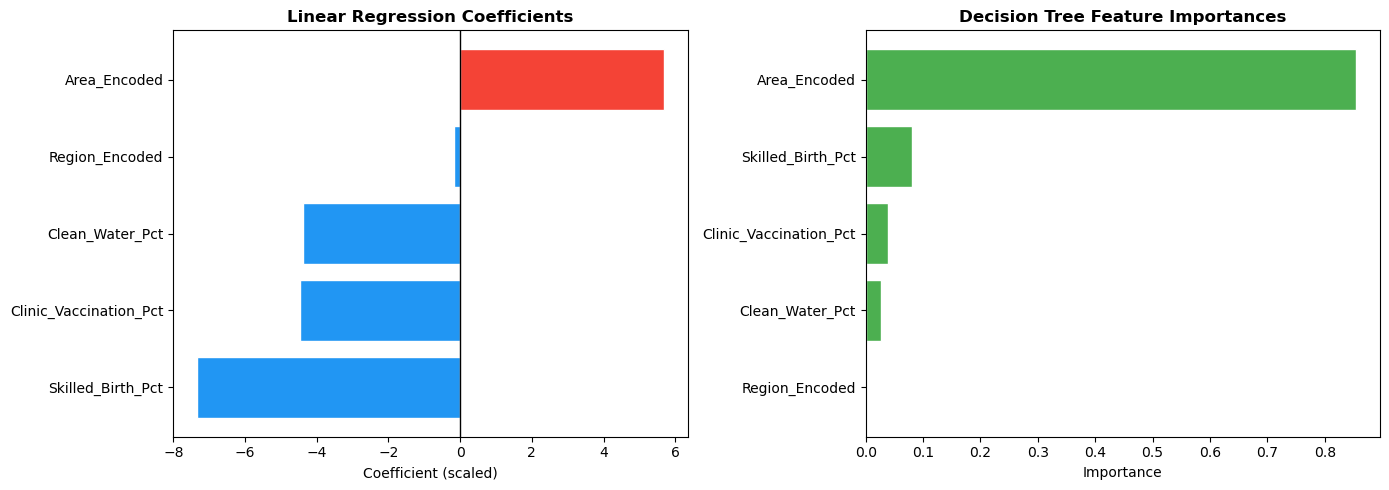

In [15]:
# Feature importance and LR coefficients side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LR Coefficients
coef_df = pd.DataFrame({'Feature': FEATURES, 'Coefficient': lr_model.coef_}).sort_values('Coefficient')
colors_c = ['#F44336' if c > 0 else '#2196F3' for c in coef_df['Coefficient']]
axes[0].barh(coef_df['Feature'], coef_df['Coefficient'], color=colors_c, edgecolor='white')
axes[0].axvline(0, color='black', linewidth=1)
axes[0].set_title('Linear Regression Coefficients', fontweight='bold')
axes[0].set_xlabel('Coefficient (scaled)')

# DT Feature Importance
imp_df = pd.DataFrame({'Feature': FEATURES, 'Importance': dt_model.feature_importances_}).sort_values('Importance')
axes[1].barh(imp_df['Feature'], imp_df['Importance'], color='#4CAF50', edgecolor='white')
axes[1].set_title('Decision Tree Feature Importances', fontweight='bold')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.show()

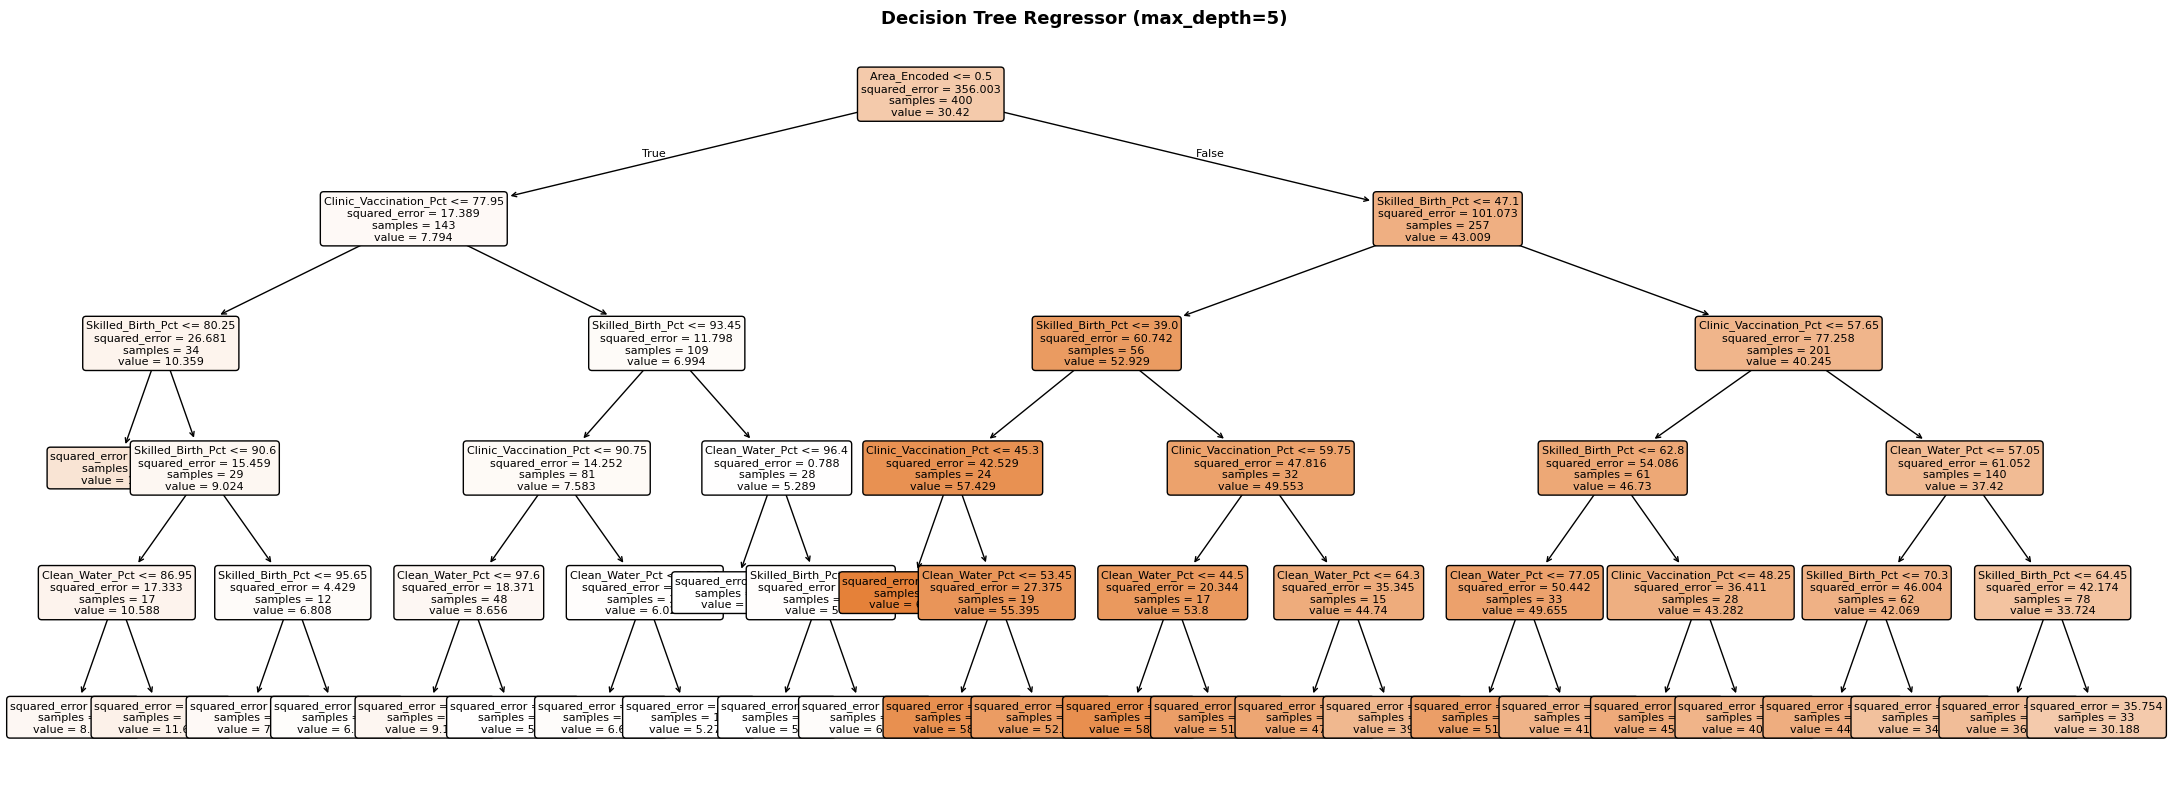

In [16]:
# Decision Tree Visualization
fig, ax = plt.subplots(figsize=(22, 8))
plot_tree(dt_model, feature_names=FEATURES, filled=True, rounded=True, fontsize=8, ax=ax)
ax.set_title('Decision Tree Regressor (max_depth=5)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Save Models (PKL Files)

In [17]:
joblib.dump(lr_model,  'lr_model.pkl')
joblib.dump(dt_model,  'dt_model.pkl')
joblib.dump(scaler,    'scaler.pkl')
joblib.dump(le_area,   'le_area.pkl')
joblib.dump(le_region, 'le_region.pkl')

meta = {
    'features':        FEATURES,
    'area_classes':    le_area.classes_.tolist(),
    'region_classes':  le_region.classes_.tolist(),
    'y_min':  float(y.min()),
    'y_max':  float(y.max()),
    'y_mean': float(y.mean()),
    'lr_r2':   round(lr_r2,   4),
    'dt_r2':   round(dt_r2,   4),
    'lr_rmse': round(lr_rmse, 4),
    'dt_rmse': round(dt_rmse, 4),
    'lr_mae':  round(lr_mae,  4),
    'dt_mae':  round(dt_mae,  4),
}
with open('model_meta.json', 'w') as f:
    json.dump(meta, f)

print('✅ Saved:')
print('  lr_model.pkl    — Linear Regression model')
print('  dt_model.pkl    — Decision Tree Regressor model')
print('  scaler.pkl      — StandardScaler for LR')
print('  le_area.pkl     — LabelEncoder for Area')
print('  le_region.pkl   — LabelEncoder for Region')
print('  model_meta.json — Metadata & metrics')

✅ Saved:
  lr_model.pkl    — Linear Regression model
  dt_model.pkl    — Decision Tree Regressor model
  scaler.pkl      — StandardScaler for LR
  le_area.pkl     — LabelEncoder for Area
  le_region.pkl   — LabelEncoder for Region
  model_meta.json — Metadata & metrics


## 8. Summary

| Metric | Linear Regression | Decision Tree |
|--------|------------------|--------------|
| **R²** | ~0.93 | ~0.90 |
| **RMSE** | ~4.7 | ~5.6 |
| **MAE** | ~3.8 | ~4.0 |

Linear Regression performs slightly better on this dataset.

**To deploy:** `streamlit run app.py`